In [34]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [35]:
words = open('names.txt', 'r').read().splitlines()

In [36]:
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [37]:
len(words)

32033

In [38]:
chars = sorted(list(set(''.join(words))))
stoi = {ch: i+1 for i, ch in enumerate(chars)}
stoi['.'] = 0
itos = {i: ch for ch, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [39]:
def buildDataset(words):
    block_size = 3
    x, y = [], []
    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            x.append(context)
            y.append(ix)
            #print(''.join ([itos[i] for i in context]), '-->', itos[ix])
            context = context[1:] + [ix]
            
    x = torch.tensor(x)
    y = torch.tensor(y)
    print(x.shape, y.shape)
    return x, y
import random
random.seed(42)
random.shuffle(words)
n1 = int (len(words)*.8)    
n2 = int (len(words)*.9)    
x_train, y_train = buildDataset(words[:n1])
x_val, y_val = buildDataset(words[n1:n2])
x_test, y_test = buildDataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [52]:
n_embd = 10
n_hidden = 200
block_size = 3

C = torch.randn(len(itos), n_embd)
W1 = torch.randn(n_embd * block_size, n_hidden) * (5/3)/(n_embd * block_size)**.5     #* .1
B1 = torch.randn(n_hidden) * 0.01
W2 = torch.randn(n_hidden, len(itos)) * .01 # To initialize the weights to be closer together
B2 = torch.randn(len(itos)) * 0.01
params = [C, W1, B1, W2, B2]
for p in params:
    p.requires_grad = True

In [53]:
max_steps = 100000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0, len(x_train), (batch_size,))
    Xb = x_train[ix]
    Yb = y_train[ix]
    
    emb = C[Xb]
    embcat = emb.view(emb.size(0), -1)
    hpreact = embcat @ W1 + B1
    h = hpreact.tanh()
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, Yb)
    
    for p in params:
        p.grad = None
    loss.backward()
    
    lr = .1
    for p in params:
        p.data -= lr * p.grad
    
        
    if i % 1000 == 0:
        print(i, loss.item())
        lr *= .98
    lossi.append(loss.log10().item())

0 3.2735865116119385
1000 2.9676191806793213
2000 2.099142074584961
3000 1.9684855937957764
4000 2.6324384212493896
5000 2.086080551147461
6000 2.284247875213623
7000 2.4746623039245605
8000 2.0719804763793945
9000 2.768636703491211
10000 2.563821792602539
11000 1.9464467763900757
12000 2.533900022506714
13000 2.1041855812072754
14000 2.394484758377075
15000 2.432321786880493
16000 1.915444254875183
17000 2.2800469398498535
18000 2.48219895362854
19000 2.5049827098846436
20000 2.0731849670410156
21000 2.5024735927581787
22000 2.0509793758392334
23000 2.4480137825012207
24000 2.1615517139434814
25000 2.114492893218994
26000 2.259075880050659
27000 2.1229312419891357
28000 2.1066441535949707
29000 2.132178783416748
30000 2.67696475982666
31000 2.426970958709717
32000 2.270646333694458
33000 2.224930763244629
34000 2.4965953826904297
35000 2.6037023067474365
36000 2.2074129581451416
37000 1.8740090131759644
38000 2.2206811904907227
39000 2.421933889389038
40000 1.9517513513565063
41000 2.

In [54]:
-torch.tensor(1/27.0).log() # expected initial loss, but it is 27 right now because the initial probabilities are not uniform

tensor(3.2958)

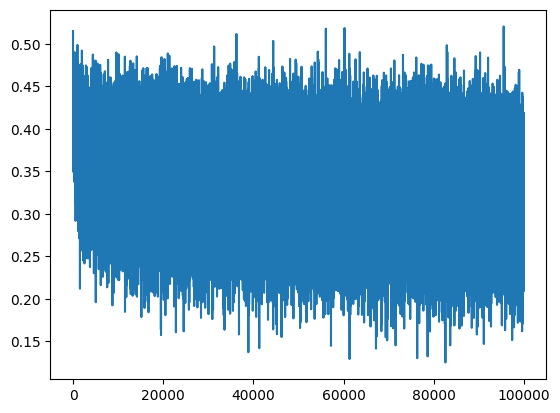

In [55]:
plt.plot(lossi)

In [56]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (x_train, y_train),
        'val': (x_val, y_val),
        'test': (x_test, y_test)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.size(0), -1)
    h = torch.tanh(embcat @ W1 + B1)
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')
    

train 2.1318764686584473
val 2.1838724613189697


initial losses after changing the initialization
train 2.180690050125122
val 2.2376396656036377

loss after fixing tanh activation
train 2.1318764686584473
val 2.1838724613189697

